In [1]:
"""
Import the library to handle the .pkl files associated to the waveform data.
"""

import matplotlib.pyplot as plt
import numpy as np

import os
import sys

libs_path = os.path.abspath(os.path.join("..", "/jupyter-workspace/private/libs"))
if libs_path not in sys.path:
    sys.path.insert(0, libs_path)

import waveform_structure
import reco_structure

In [2]:
run = 13830

wave_path = '/jupyter-workspace/private/run_data/waveforms/'
reco_path = '/jupyter-workspace/private/run_data/reco/'

reco = reco_structure.ExtractData(run, reco_path, waveform=None, config_file='ConfigFile_DataProcess.txt', mode='custom') 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
from scipy.spatial.distance import cdist
from scipy.ndimage import binary_closing
from skimage.morphology import skeletonize
import networkx as nx
from tqdm import tqdm

class CurvedTrackAnalyzer:
    def __init__(self, reco, rebin_factor=4, gap_threshold=30):
        self.reco = reco
        self.rebin = int(rebin_factor)
        self.gap_threshold_coarse = gap_threshold / self.rebin 
        self.data = self._analyze_all()

    def get_data(self):
        return self.data

    def _analyze_all(self):
        redpix = self.reco.get_redpix()
        rx, ry, rz = redpix[0], redpix[1], redpix[2]
        n_images = len(rx)
        
        data = []
        for i in tqdm(range(n_images)):
            n_clu = len(rx[i])
            for c in range(n_clu):
                x = rx[i][c]
                y = ry[i][c]
                z = rz[i][c]
                
                if len(x) < 10:
                     data.append(self._empty_track(i, c, x, y, z))
                     continue

                track_dict = self._process_track(x, y, z)
                track_dict['image_idx'] = i
                track_dict['cluster_idx'] = c
                data.append(track_dict)
        return data

    def _empty_track(self, i, c, x, y, z):
        return {
            'image_idx': i, 'cluster_idx': c,
            'sc_length': 0, 'sc_width': 0,
            'redpix_ix': x, 'redpix_iy': y, 'redpix_iz': z,
            'spine_x': [], 'spine_y': [],
            's_coords': np.zeros(len(x)), 't_coords': np.zeros(len(x))
        }

    def _bridge_graph_gaps(self, G):
        components = list(nx.connected_components(G))
        if len(components) < 2:
            return G
            
        comp_endpoints = []
        for comp in components:
            endpoints = [n for n in comp if G.degree(n) == 1]
            if not endpoints:
                endpoints = list(comp)
            comp_endpoints.append(endpoints)
        
        for i in range(len(components)):
            for j in range(i + 1, len(components)):
                nodes_i = comp_endpoints[i]
                nodes_j = comp_endpoints[j]
                
                min_dist = float('inf')
                best_pair = None
                
                for u in nodes_i:
                    u_pos = np.array(G.nodes[u]['pos'])
                    for v in nodes_j:
                        v_pos = np.array(G.nodes[v]['pos'])
                        dist = np.linalg.norm(u_pos - v_pos)
                        
                        if dist < min_dist:
                            min_dist = dist
                            best_pair = (u, v)
                            
                if min_dist <= self.gap_threshold_coarse and best_pair:
                    # Bridge with high resistance but valid physical length
                    G.add_edge(best_pair[0], best_pair[1], weight=min_dist * 3.0, phys_len=min_dist)
                    
        return G

    def _process_track(self, x, y, z):
        x = np.array(x)
        y = np.array(y)
        z = np.array(z)
        
        x_int = x.astype(int)
        y_int = y.astype(int)
        
        min_x, max_x = np.min(x_int), np.max(x_int)
        min_y, max_y = np.min(y_int), np.max(y_int)
        
        pad = 2
        w_raw = max_x - min_x + 1
        h_raw = max_y - min_y + 1
        w_coarse = (w_raw // self.rebin) + 1 + 2*pad
        h_coarse = (h_raw // self.rebin) + 1 + 2*pad
        
        grid_bin = np.zeros((h_coarse, w_coarse), dtype=int)
        grid_int = np.zeros((h_coarse, w_coarse), dtype=float)
        
        xc = (x_int - min_x) // self.rebin + pad
        yc = (y_int - min_y) // self.rebin + pad
        
        grid_bin[yc, xc] = 1
        np.add.at(grid_int, (yc, xc), z)
        
        grid_bin = binary_closing(grid_bin, structure=np.ones((3,3))).astype(int)
        
        skel = skeletonize(grid_bin)
        sy, sx = np.where(skel)
        
        if len(sx) < 3:
             return self._process_linear_fallback(x, y, z)
             
        G = nx.Graph()
        nodes = list(zip(sx, sy))
        node_to_idx = {n: i for i, n in enumerate(nodes)}
        
        max_val = np.max(grid_int) if np.max(grid_int) > 0 else 1.0
        
        best_node = 0
        max_node_int = -1.0
        
        for i, (u_x, u_y) in enumerate(nodes):
            G.add_node(i, pos=(u_x, u_y))
            
            y_slice = slice(max(0, u_y-1), min(h_coarse, u_y+2))
            x_slice = slice(max(0, u_x-1), min(w_coarse, u_x+2))
            local_int = np.mean(grid_int[y_slice, x_slice])
            
            if local_int > max_node_int:
                max_node_int = local_int
                best_node = i
            
            brightness = local_int / max_val
            cost_factor = 1.0 + 15.0 * (1.0 - brightness)**2

            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    if dx == 0 and dy == 0: continue
                    v = (u_x + dx, u_y + dy)
                    if v in node_to_idx:
                        j = node_to_idx[v]
                        dist = np.sqrt(dx**2 + dy**2)
                        # Store both 'weight' (resistance) and 'phys_len' (actual distance)
                        G.add_edge(i, j, weight=dist * cost_factor, phys_len=dist)

        G = self._bridge_graph_gaps(G)

        # --- KEY CHANGE: Minimum Spanning Tree ---
        # This breaks all cycles (shortcuts) by keeping only the cheapest (brightest) connections.
        MST = nx.minimum_spanning_tree(G, weight='weight')
        # -----------------------------------------

        try:
            # Pass 1: Find End A (Farthest PHYSICAL distance from Brightest Node on MST)
            # On a tree, path is unique, so Dijkstra just measures distance.
            lengths_1 = nx.single_source_dijkstra_path_length(MST, best_node, weight='phys_len')
            end_a = max(lengths_1, key=lengths_1.get)
            
            # Pass 2: Find End B (Farthest PHYSICAL distance from End A on MST)
            lengths_2 = nx.single_source_dijkstra_path_length(MST, end_a, weight='phys_len')
            end_b = max(lengths_2, key=lengths_2.get)
            
            longest_path = nx.shortest_path(MST, source=end_a, target=end_b, weight='phys_len')
            
        except (nx.NetworkXNoPath, ValueError):
            return self._process_linear_fallback(x, y, z)

        spine_nodes = np.array([G.nodes[n]['pos'] for n in longest_path])
        sp_x_coarse = spine_nodes[:, 0]
        sp_y_coarse = spine_nodes[:, 1]
        
        sp_x = (sp_x_coarse - pad) * self.rebin + min_x + (self.rebin / 2.0)
        sp_y = (sp_y_coarse - pad) * self.rebin + min_y + (self.rebin / 2.0)
        
        diffs = np.sqrt(np.diff(sp_x)**2 + np.diff(sp_y)**2)
        u_vals = np.concatenate(([0], np.cumsum(diffs)))
        if u_vals[-1] == 0:
            return self._process_linear_fallback(x, y, z)
            
        u_vals /= u_vals[-1]
        
        try:
            k = min(3, len(sp_x)-1)
            tck, u = splprep([sp_x, sp_y], u=u_vals, k=k, s=self.rebin * 10)
        except:
             return self._process_linear_fallback(x, y, z)

        u_fine = np.linspace(0, 1, max(100, len(sp_x)*10))
        spline_pts = np.array(splev(u_fine, tck)).T
        
        pix_pts = np.column_stack((x, y))
        dists = cdist(pix_pts, spline_pts)
        min_indices = np.argmin(dists, axis=1)
        
        t_coords = dists[np.arange(len(dists)), min_indices]
        
        fine_diffs = np.sqrt(np.diff(spline_pts[:,0])**2 + np.diff(spline_pts[:,1])**2)
        total_len = np.sum(fine_diffs)
        
        s_map = np.concatenate(([0], np.cumsum(fine_diffs)))
        s_coords = s_map[min_indices]
        out_spine = np.array(splev(np.linspace(0, 1, 300), tck))

        return {
            'sc_length': total_len,
            'sc_width': np.std(t_coords),
            'redpix_ix': x, 'redpix_iy': y, 'redpix_iz': z,
            'spine_x': out_spine[0], 'spine_y': out_spine[1],
            's_coords': s_coords,
            't_coords': t_coords
        }

    def _process_linear_fallback(self, x, y, z):
        if len(x) < 2:
             return self._empty_track(0, 0, x, y, z)
             
        pts = np.column_stack((x, y))
        mean = np.mean(pts, axis=0)
        centered = pts - mean
        cov = np.cov(centered.T)
        evals, evecs = np.linalg.eig(cov)
        idx = np.argsort(evals)[::-1]
        e1 = evecs[:, idx[0]]
        e2 = evecs[:, idx[1]]
        
        proj = centered.dot(e1)
        s_coords = proj - np.min(proj)
        t_coords = centered.dot(e2)
        
        p1 = mean + e1 * np.min(proj)
        p2 = mean + e1 * np.max(proj)
        
        return {
            'sc_length': np.max(s_coords),
            'sc_width': np.std(t_coords),
            'redpix_ix': x, 'redpix_iy': y, 'redpix_iz': z,
            'spine_x': np.array([p1[0], p2[0]]), 'spine_y': np.array([p1[1], p2[1]]),
            's_coords': s_coords,
            't_coords': t_coords
        }

    def plot(self, index):
        if index < 0 or index >= len(self.data):
            print(f"Index {index} out of range")
            return

        data = self.data[index]
        x = data['redpix_ix']
        y = data['redpix_iy']
        z = data['redpix_iz']
        
        if len(x) == 0:
            print("Empty track")
            return

        sx = data['spine_x']
        sy = data['spine_y']
        s = data['s_coords']
        t = data['t_coords']
        
        fig, ax = plt.subplots(1, 3, figsize=(18, 5))
        
        ax[0].scatter(x, y, c=z, cmap='jet', s=10)
        if len(sx) > 0:
            ax[0].plot(sx, sy, 'r-', linewidth=2, label='Spine')
        ax[0].set_title(f'Track {index} (Img {data["image_idx"]})')
        ax[0].invert_yaxis()
        ax[0].set_aspect('equal')
        
        ax[1].scatter(s, t, c=z, cmap='jet', s=10)
        ax[1].set_title('Straightened Space (s, t)')
        ax[1].set_xlabel('s [px]')
        ax[1].set_ylabel('t [px]')
        ax[1].grid(linestyle='--', linewidth=0.5)
        
        nbins = 50
        if len(s) > 0:
            hist, edges = np.histogram(s, bins=nbins, weights=z)
            centers = (edges[:-1] + edges[1:]) / 2
            ax[2].step(centers, hist, where='mid', color='blue')
        ax[2].set_title('Longitudinal Profile (dE/ds)')
        ax[2].set_xlabel('s [px]')
        ax[2].set_ylabel('Charge [ADU]')
        ax[2].grid(linestyle='--', linewidth=0.5)
        
        plt.tight_layout()
        plt.show()

    def plot_debug(self, index):
        if index < 0 or index >= len(self.data):
            print(f"Index {index} out of range")
            return
            
        tdata = self.data[index]
        x = tdata['redpix_ix']
        y = tdata['redpix_iy']
        z = tdata['redpix_iz']
        
        if len(x) == 0: return

        x_int = x.astype(int)
        y_int = y.astype(int)
        min_x, max_x = np.min(x_int), np.max(x_int)
        min_y, max_y = np.min(y_int), np.max(y_int)
        pad = 2
        w_raw = max_x - min_x + 1
        h_raw = max_y - min_y + 1
        w_coarse = (w_raw // self.rebin) + 1 + 2*pad
        h_coarse = (h_raw // self.rebin) + 1 + 2*pad
        
        grid_bin = np.zeros((h_coarse, w_coarse), dtype=int)
        grid_int = np.zeros((h_coarse, w_coarse), dtype=float)
        xc = (x_int - min_x) // self.rebin + pad
        yc = (y_int - min_y) // self.rebin + pad
        grid_bin[yc, xc] = 1
        np.add.at(grid_int, (yc, xc), z)
        
        grid_closed = binary_closing(grid_bin, structure=np.ones((3,3))).astype(int)
        skel = skeletonize(grid_closed)
        
        fig, ax = plt.subplots(1, 4, figsize=(24, 6))
        
        ax[0].scatter(x, y, c=z, cmap='jet', s=10)
        ax[0].set_title("1. Original Cluster")
        ax[0].invert_yaxis()
        ax[0].set_aspect('equal')
        
        ax[1].imshow(grid_int, cmap='magma', origin='upper')
        ax[1].set_title(f"2. Rebinned Intensity (Factor {self.rebin})")
        
        ax[2].imshow(skel, cmap='gray', origin='upper')
        sy, sx = np.where(skel)
        ax[2].scatter(sx, sy, c='red', s=5, alpha=0.7)
        ax[2].set_title("3. Skeleton & Graph Nodes")
        
        ax[3].scatter(x, y, c=z, cmap='jet', s=5, alpha=0.5)
        if len(tdata['spine_x']) > 0:
            ax[3].plot(tdata['spine_x'], tdata['spine_y'], 'r-', linewidth=2)
        ax[3].set_title("4. Final Spine Fit")
        ax[3].invert_yaxis()
        ax[3].set_aspect('equal')
        
        plt.tight_layout()
        plt.show()

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
from scipy.spatial.distance import cdist
from scipy.spatial import cKDTree
from scipy.ndimage import binary_closing
from skimage.morphology import skeletonize
import networkx as nx
from tqdm import tqdm

class CurvedTrackAnalyzer:
    def __init__(self, reco, rebin_factor=4, gap_threshold=30):
        self.reco = reco
        self.rebin = int(rebin_factor)
        self.gap_threshold_coarse = gap_threshold / self.rebin 
        self.data = self._analyze_all()

    def get_data(self):
        return self.data

    def _analyze_all(self):
        redpix = self.reco.get_redpix()
        rx, ry, rz = redpix[0], redpix[1], redpix[2]
        n_images = len(rx)
        
        data = []
        for i in tqdm(range(n_images)):
            n_clu = len(rx[i])
            for c in range(n_clu):
                x = rx[i][c]
                y = ry[i][c]
                z = rz[i][c]
                
                if len(x) < 10:
                     data.append(self._empty_track(i, c, x, y, z))
                     continue

                track_dict = self._process_track(x, y, z)
                track_dict['image_idx'] = i
                track_dict['cluster_idx'] = c
                data.append(track_dict)
        return data

    def _empty_track(self, i, c, x, y, z):
        return {
            'image_idx': i, 'cluster_idx': c,
            'sc_length': 0, 'sc_width': 0,
            'redpix_ix': x, 'redpix_iy': y, 'redpix_iz': z,
            'spine_x': [], 'spine_y': [],
            's_coords': np.zeros(len(x)), 't_coords': np.zeros(len(x))
        }

    def _bridge_graph_gaps(self, G):
        components = list(nx.connected_components(G))
        if len(components) < 2:
            return G
            
        all_endpoints = []
        endpoint_map = {}
        
        for comp_idx, comp in enumerate(components):
            comp_nodes = [n for n in comp if G.degree(n) == 1]
            if not comp_nodes:
                comp_nodes = list(comp)
            
            for node in comp_nodes:
                pos = G.nodes[node]['pos']
                all_endpoints.append(pos)
                endpoint_map[tuple(pos)] = (node, comp_idx)
        
        if not all_endpoints:
            return G
            
        points = np.array(all_endpoints)
        tree = cKDTree(points)
        
        pairs = tree.query_pairs(r=self.gap_threshold_coarse)
        
        for i, j in pairs:
            p1 = tuple(points[i])
            p2 = tuple(points[j])
            
            node1, comp1 = endpoint_map[p1]
            node2, comp2 = endpoint_map[p2]
            
            if comp1 != comp2:
                dist = np.linalg.norm(np.array(p1) - np.array(p2))
                G.add_edge(node1, node2, weight=dist * 3.0, phys_len=dist)
                
        return G

    def _process_track(self, x, y, z):
        x = np.array(x)
        y = np.array(y)
        z = np.array(z)
        
        x_int = x.astype(int)
        y_int = y.astype(int)
        
        min_x, max_x = np.min(x_int), np.max(x_int)
        min_y, max_y = np.min(y_int), np.max(y_int)
        
        pad = 2
        w_raw = max_x - min_x + 1
        h_raw = max_y - min_y + 1
        w_coarse = (w_raw // self.rebin) + 1 + 2*pad
        h_coarse = (h_raw // self.rebin) + 1 + 2*pad
        
        grid_bin = np.zeros((h_coarse, w_coarse), dtype=int)
        grid_int = np.zeros((h_coarse, w_coarse), dtype=float)
        
        xc = (x_int - min_x) // self.rebin + pad
        yc = (y_int - min_y) // self.rebin + pad
        
        grid_bin[yc, xc] = 1
        np.add.at(grid_int, (yc, xc), z)
        
        grid_bin = binary_closing(grid_bin, structure=np.ones((3,3))).astype(int)
        
        skel = skeletonize(grid_bin)
        sy, sx = np.where(skel)
        
        if len(sx) < 3:
             return self._process_linear_fallback(x, y, z)
             
        G = nx.Graph()
        nodes = list(zip(sx, sy))
        node_to_idx = {n: i for i, n in enumerate(nodes)}
        
        max_val = np.max(grid_int) if np.max(grid_int) > 0 else 1.0
        
        for i, (u_x, u_y) in enumerate(nodes):
            G.add_node(i, pos=(u_x, u_y))
            
            y_slice = slice(max(0, u_y-1), min(h_coarse, u_y+2))
            x_slice = slice(max(0, u_x-1), min(w_coarse, u_x+2))
            local_int = np.mean(grid_int[y_slice, x_slice])
            
            brightness = local_int / max_val
            cost_factor = 1.0 + 5.0 * (1.0 - brightness)**2

            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    if dx == 0 and dy == 0: continue
                    v = (u_x + dx, u_y + dy)
                    if v in node_to_idx:
                        j = node_to_idx[v]
                        dist = np.sqrt(dx**2 + dy**2)
                        G.add_edge(i, j, weight=dist * cost_factor, phys_len=dist)

        G = self._bridge_graph_gaps(G)

        MST = nx.minimum_spanning_tree(G, weight='weight')
        
        endpoints = [n for n, d in MST.degree() if d == 1]
        
        if not endpoints:
             if len(MST.nodes) > 1:
                 endpoints = [list(MST.nodes)[0]]
             else:
                 return self._process_linear_fallback(x, y, z)
        
        best_path = []
        max_phys_len = -1.0
        
        start_node = endpoints[0]

        lengths_from_start = nx.single_source_dijkstra_path_length(MST, start_node, weight='phys_len')
        node_b = max(lengths_from_start, key=lengths_from_start.get)

        lengths_from_b = nx.single_source_dijkstra_path_length(MST, node_b, weight='phys_len')
        node_c = max(lengths_from_b, key=lengths_from_b.get)
        
        best_path = nx.shortest_path(MST, source=node_b, target=node_c, weight='phys_len')

        if not best_path:
             return self._process_linear_fallback(x, y, z)

        spine_nodes = np.array([G.nodes[n]['pos'] for n in best_path])
        sp_x_coarse = spine_nodes[:, 0]
        sp_y_coarse = spine_nodes[:, 1]
        
        sp_x = (sp_x_coarse - pad) * self.rebin + min_x + (self.rebin / 2.0)
        sp_y = (sp_y_coarse - pad) * self.rebin + min_y + (self.rebin / 2.0)
        
        diffs = np.sqrt(np.diff(sp_x)**2 + np.diff(sp_y)**2)
        u_vals = np.concatenate(([0], np.cumsum(diffs)))
        if u_vals[-1] == 0:
            return self._process_linear_fallback(x, y, z)
            
        u_vals /= u_vals[-1]
        
        try:
            k = min(3, len(sp_x)-1)
            tck, u = splprep([sp_x, sp_y], u=u_vals, k=k, s=self.rebin * 10)
        except:
             return self._process_linear_fallback(x, y, z)

        u_fine = np.linspace(0, 1, max(100, len(sp_x)*10))
        spline_pts = np.array(splev(u_fine, tck)).T
        
        pix_pts = np.column_stack((x, y))
        dists = cdist(pix_pts, spline_pts)
        min_indices = np.argmin(dists, axis=1)
        
        t_coords = dists[np.arange(len(dists)), min_indices]
        
        fine_diffs = np.sqrt(np.diff(spline_pts[:,0])**2 + np.diff(spline_pts[:,1])**2)
        total_len = np.sum(fine_diffs)
        
        s_map = np.concatenate(([0], np.cumsum(fine_diffs)))
        s_coords = s_map[min_indices]
        out_spine = np.array(splev(np.linspace(0, 1, 300), tck))

        return {
            'sc_length': total_len,
            'sc_width': np.std(t_coords),
            'redpix_ix': x, 'redpix_iy': y, 'redpix_iz': z,
            'spine_x': out_spine[0], 'spine_y': out_spine[1],
            's_coords': s_coords,
            't_coords': t_coords
        }

    def _process_linear_fallback(self, x, y, z):
        if len(x) < 2:
             return self._empty_track(0, 0, x, y, z)
             
        pts = np.column_stack((x, y))
        mean = np.mean(pts, axis=0)
        centered = pts - mean
        cov = np.cov(centered.T)
        evals, evecs = np.linalg.eig(cov)
        idx = np.argsort(evals)[::-1]
        e1 = evecs[:, idx[0]]
        e2 = evecs[:, idx[1]]
        
        proj = centered.dot(e1)
        s_coords = proj - np.min(proj)
        t_coords = centered.dot(e2)
        
        p1 = mean + e1 * np.min(proj)
        p2 = mean + e1 * np.max(proj)
        
        return {
            'sc_length': np.max(s_coords),
            'sc_width': np.std(t_coords),
            'redpix_ix': x, 'redpix_iy': y, 'redpix_iz': z,
            'spine_x': np.array([p1[0], p2[0]]), 'spine_y': np.array([p1[1], p2[1]]),
            's_coords': s_coords,
            't_coords': t_coords
        }

    def plot_debug(self, index):
        if index < 0 or index >= len(self.data):
            print(f"Index {index} out of range")
            return
            
        tdata = self.data[index]
        x = tdata['redpix_ix']
        y = tdata['redpix_iy']
        z = tdata['redpix_iz']
        
        if len(x) == 0: return

        x_int = x.astype(int)
        y_int = y.astype(int)
        min_x, max_x = np.min(x_int), np.max(x_int)
        min_y, max_y = np.min(y_int), np.max(y_int)
        pad = 2
        w_raw = max_x - min_x + 1
        h_raw = max_y - min_y + 1
        w_coarse = (w_raw // self.rebin) + 1 + 2*pad
        h_coarse = (h_raw // self.rebin) + 1 + 2*pad
        
        grid_bin = np.zeros((h_coarse, w_coarse), dtype=int)
        grid_int = np.zeros((h_coarse, w_coarse), dtype=float)
        xc = (x_int - min_x) // self.rebin + pad
        yc = (y_int - min_y) // self.rebin + pad
        grid_bin[yc, xc] = 1
        np.add.at(grid_int, (yc, xc), z)
        
        grid_closed = binary_closing(grid_bin, structure=np.ones((3,3))).astype(int)
        skel = skeletonize(grid_closed)
        
        fig, ax = plt.subplots(1, 4, figsize=(24, 6))
        
        ax[0].scatter(x, y, c=z, cmap='jet', s=10)
        ax[0].set_title("1. Original Cluster")
        ax[0].invert_yaxis()
        ax[0].set_aspect('equal')
        
        ax[1].imshow(grid_int, cmap='magma', origin='upper')
        ax[1].set_title(f"2. Rebinned Intensity (Factor {self.rebin})")
        
        ax[2].imshow(skel, cmap='gray', origin='upper')
        sy, sx = np.where(skel)
        ax[2].scatter(sx, sy, c='red', s=5, alpha=0.7)
        ax[2].set_title("3. Skeleton & Graph Nodes")
        
        ax[3].scatter(x, y, c=z, cmap='jet', s=5, alpha=0.5)
        if len(tdata['spine_x']) > 0:
            ax[3].plot(tdata['spine_x'], tdata['spine_y'], 'r-', linewidth=2)
        ax[3].set_title("4. Final Spine Fit")
        ax[3].invert_yaxis()
        ax[3].set_aspect('equal')
        
        plt.tight_layout()
        plt.show()

In [17]:
curved = CurvedTrackAnalyzer(reco, rebin_factor=4, gap_threshold=60)

100%|██████████| 500/500 [06:18<00:00,  1.32it/s]


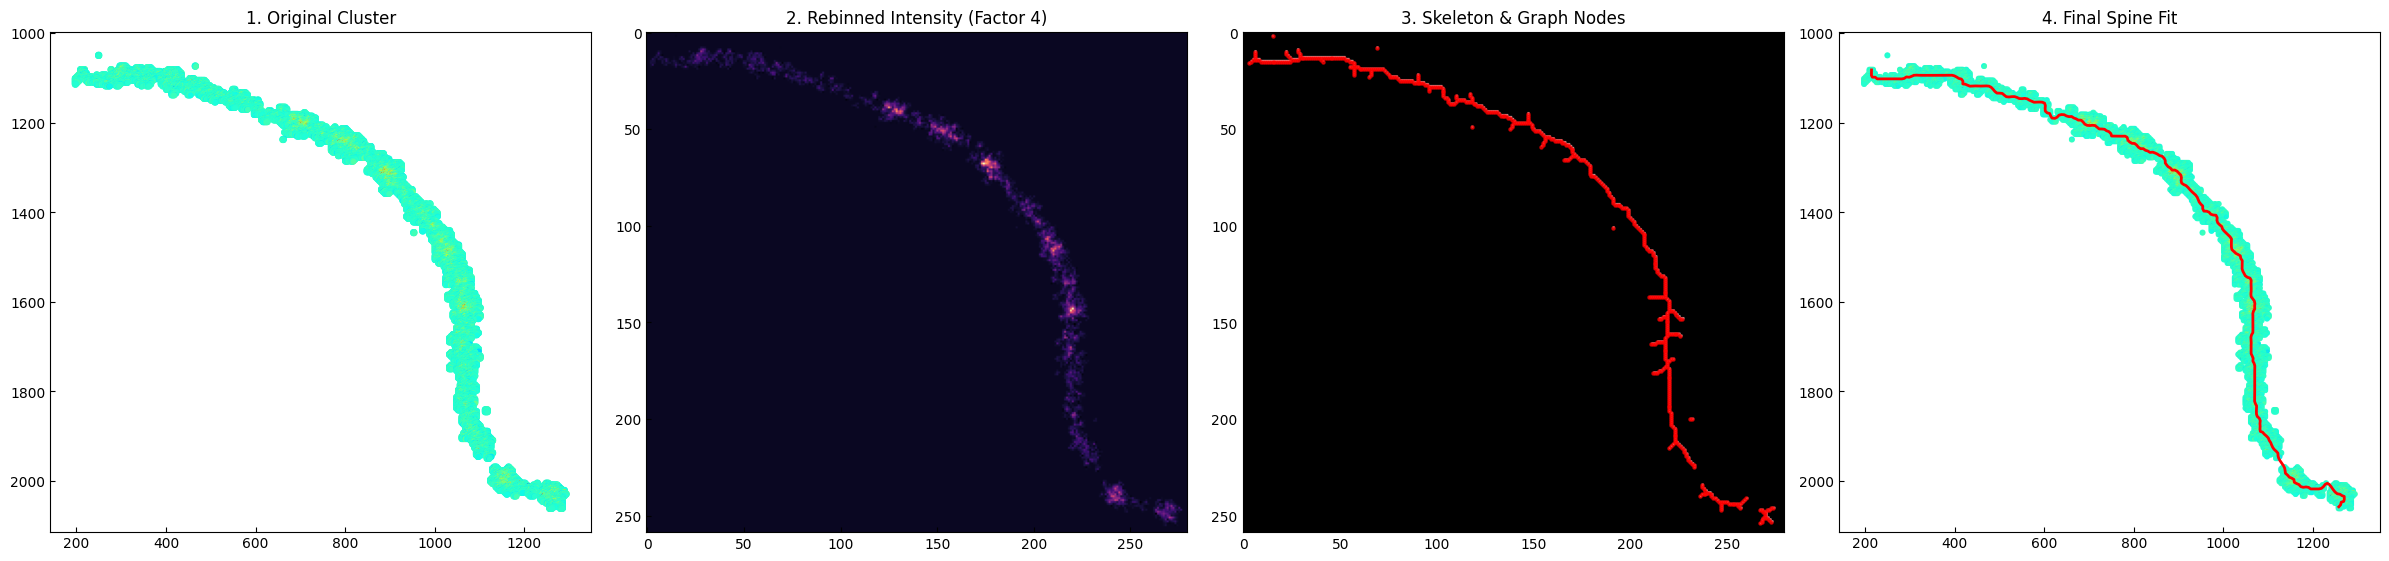

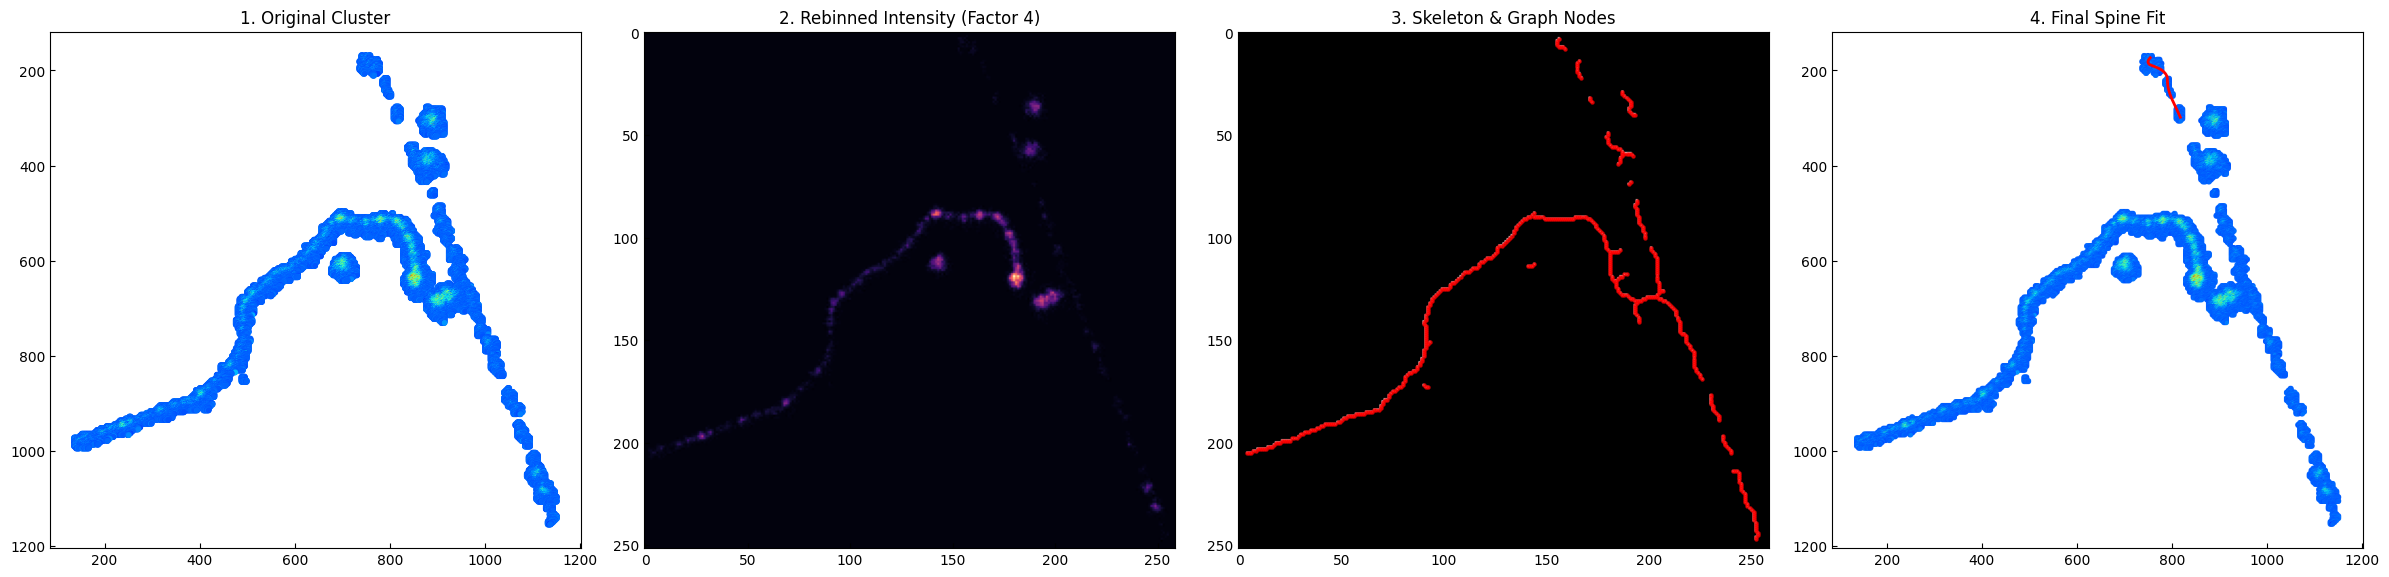

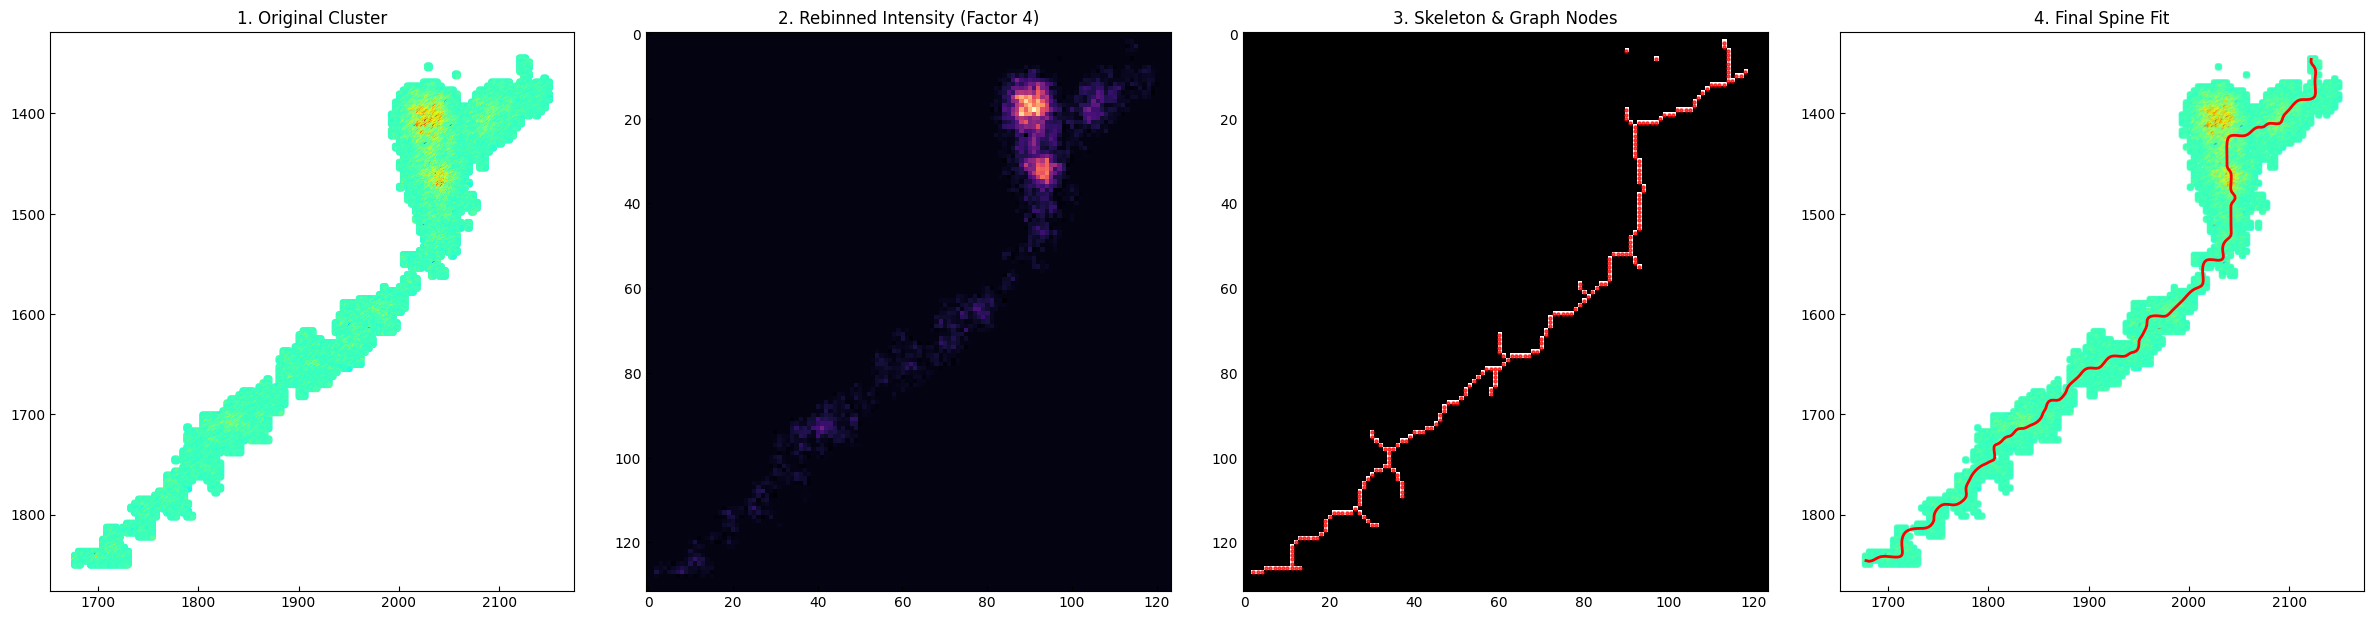

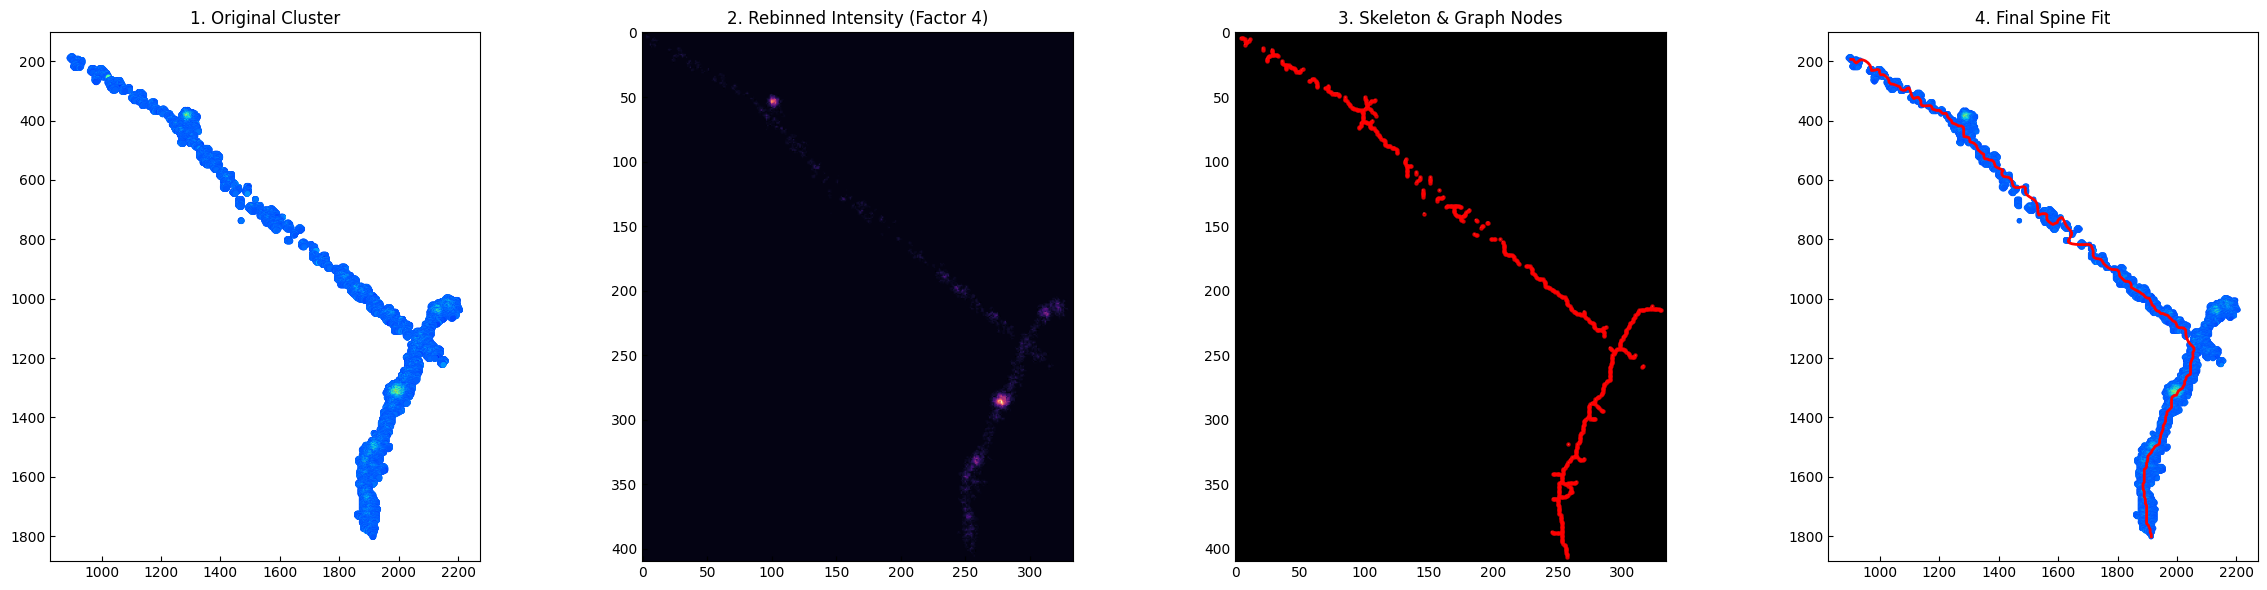

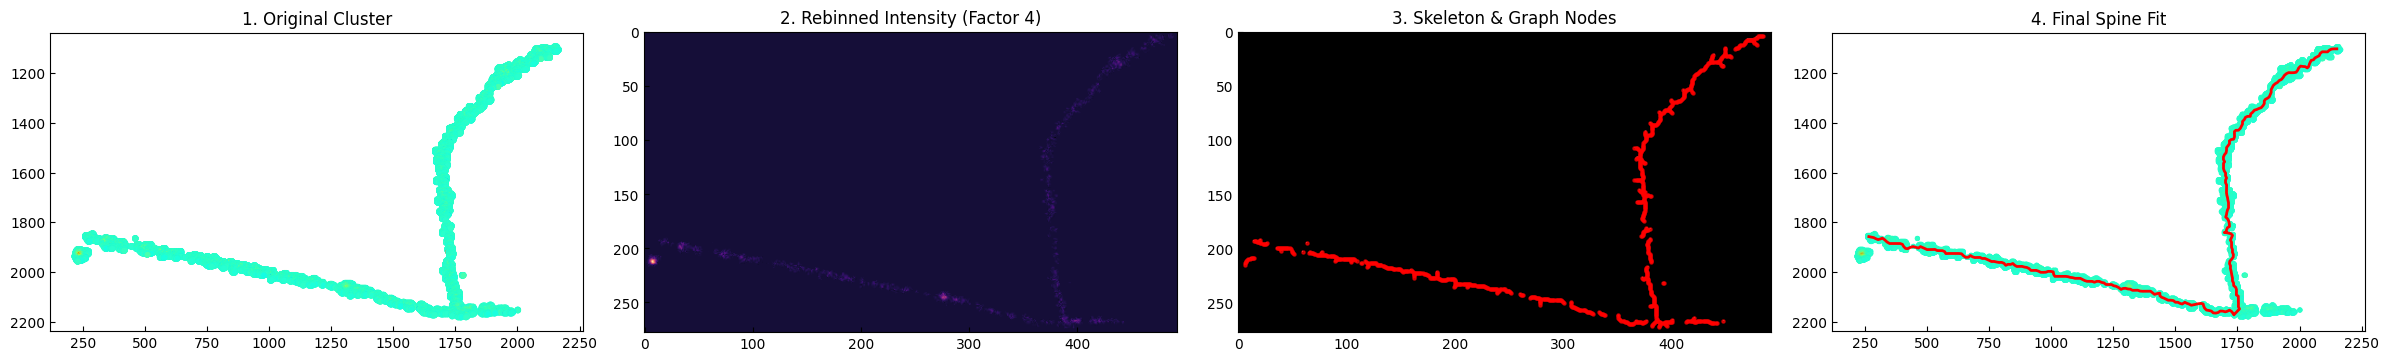

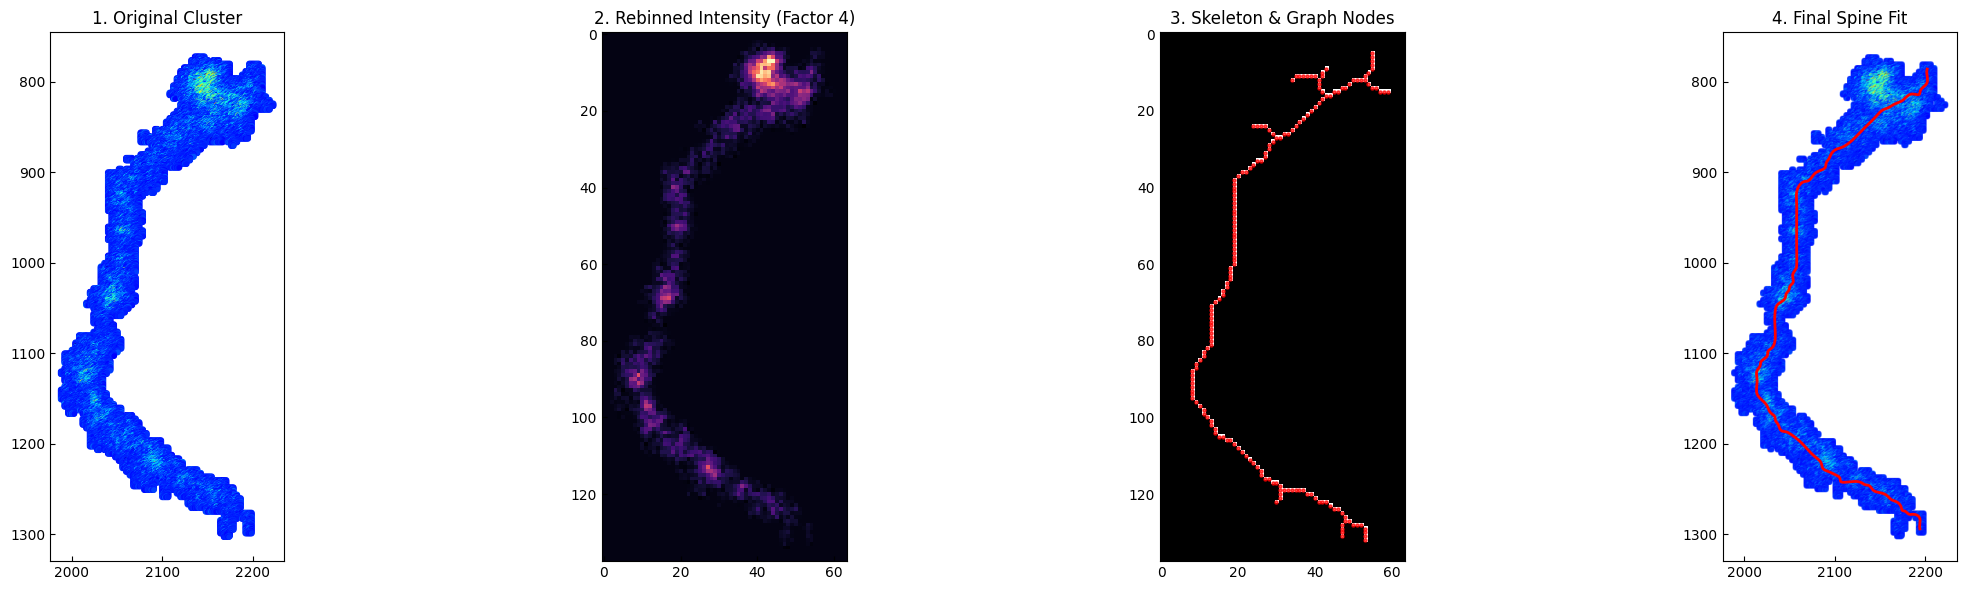

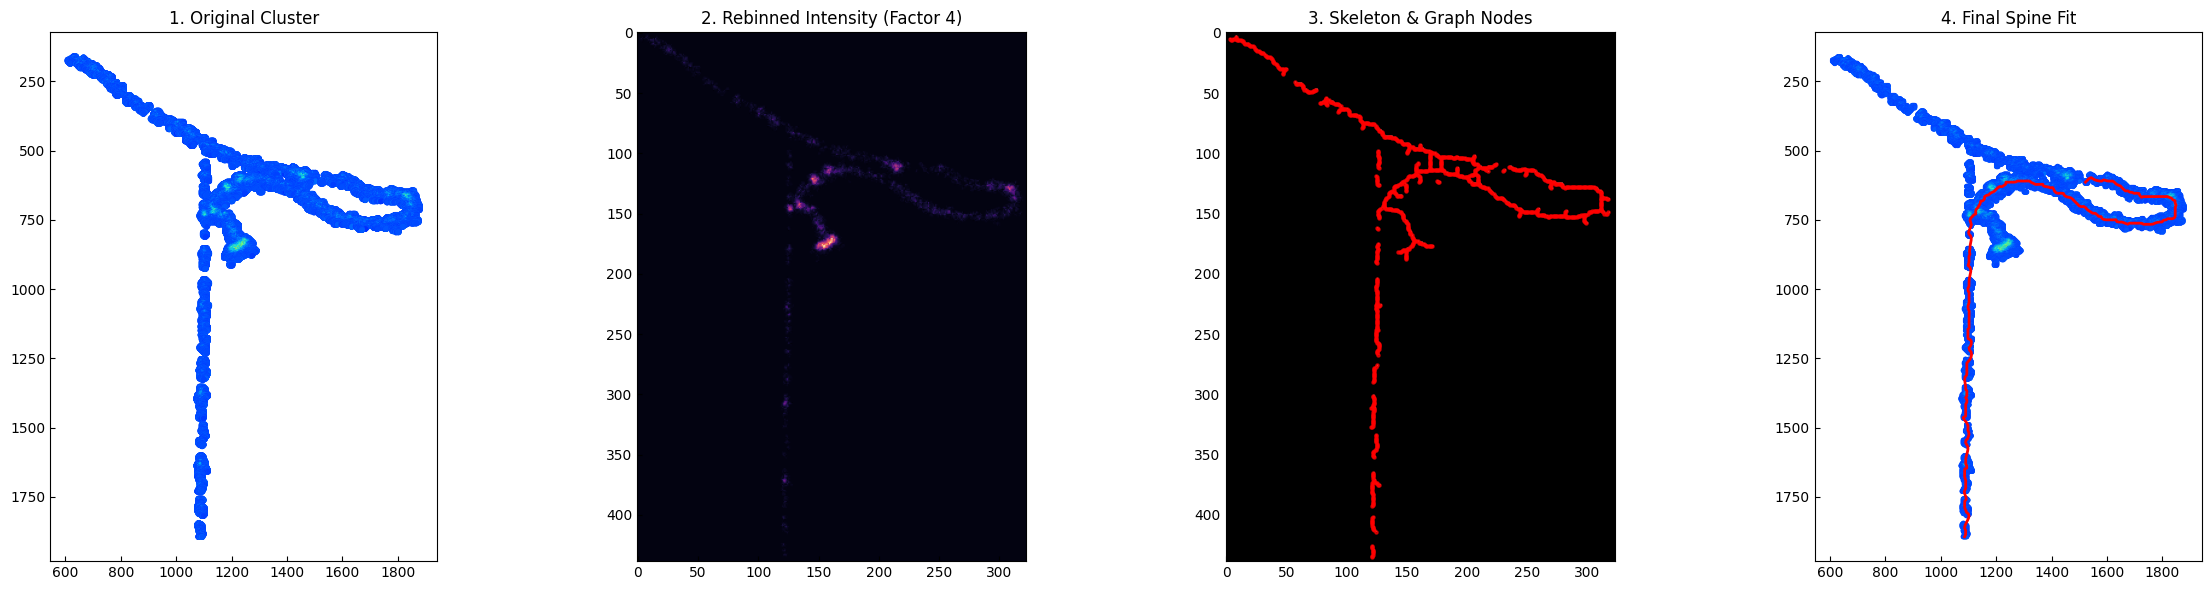

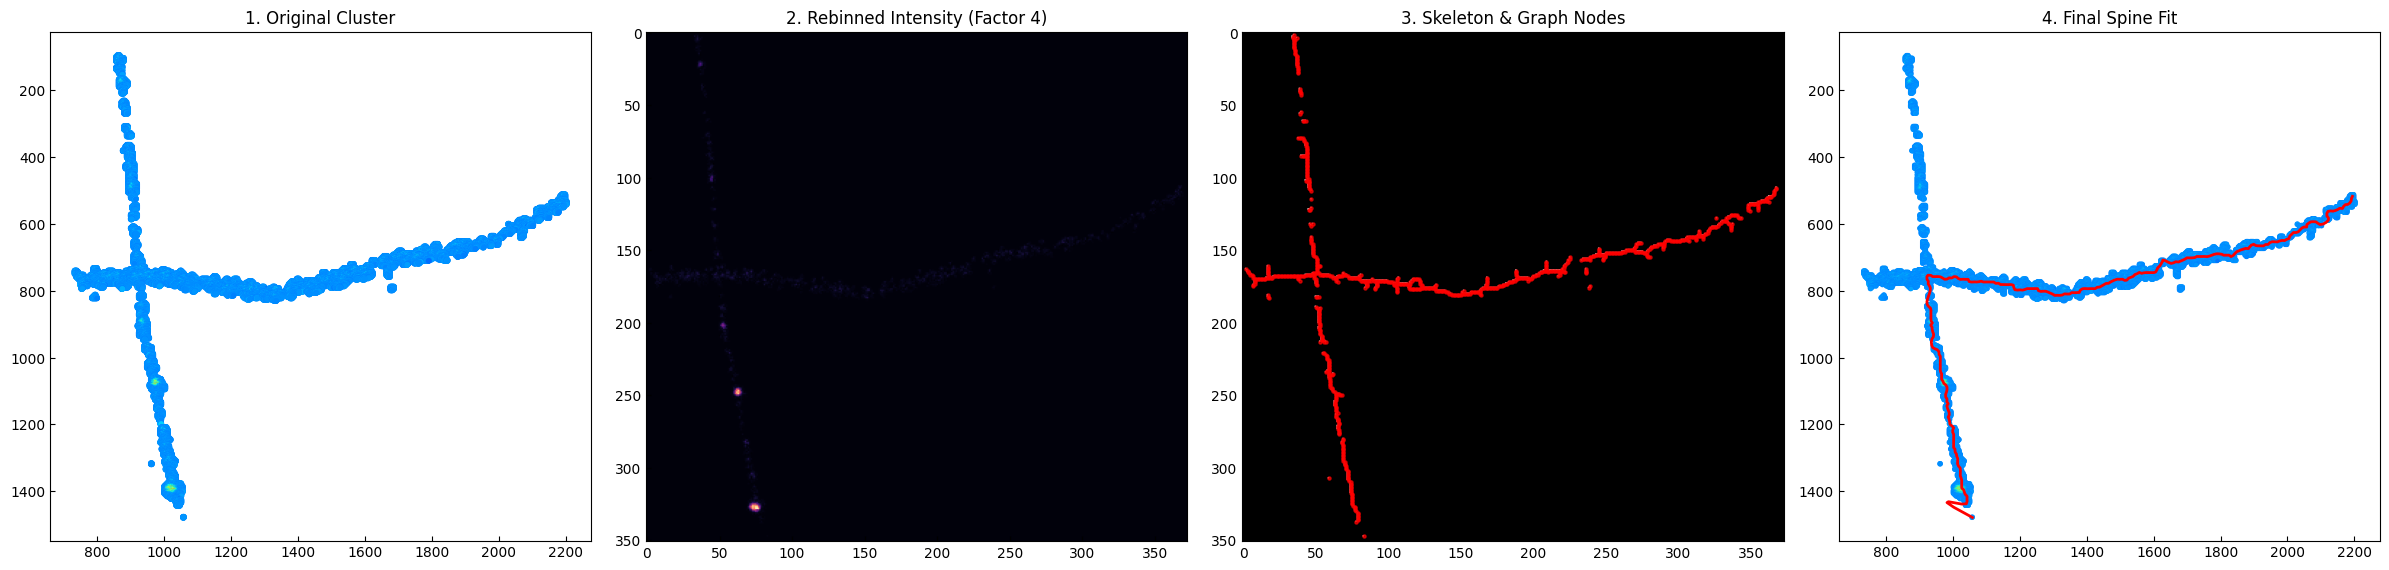

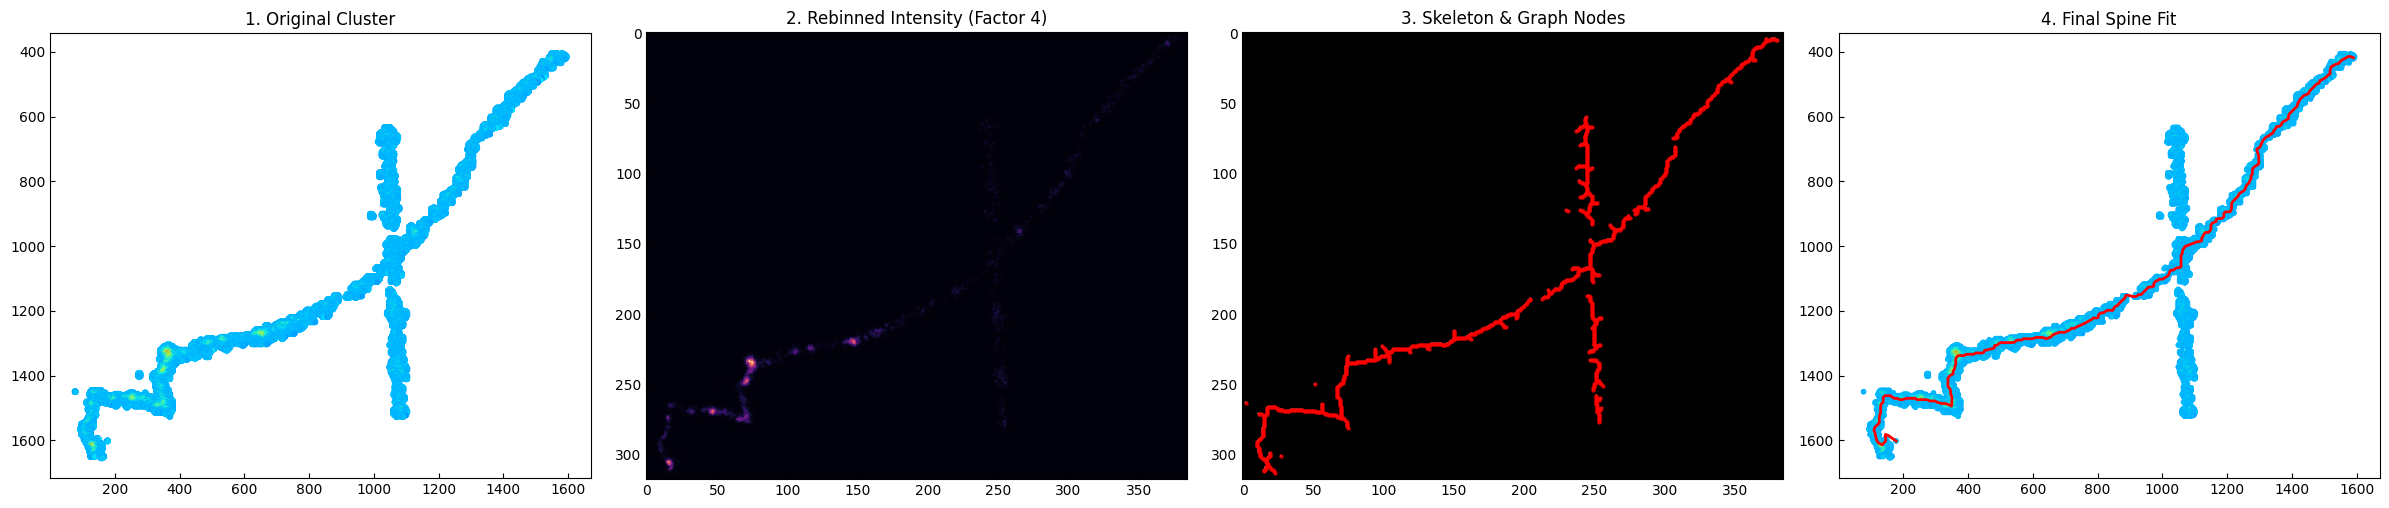

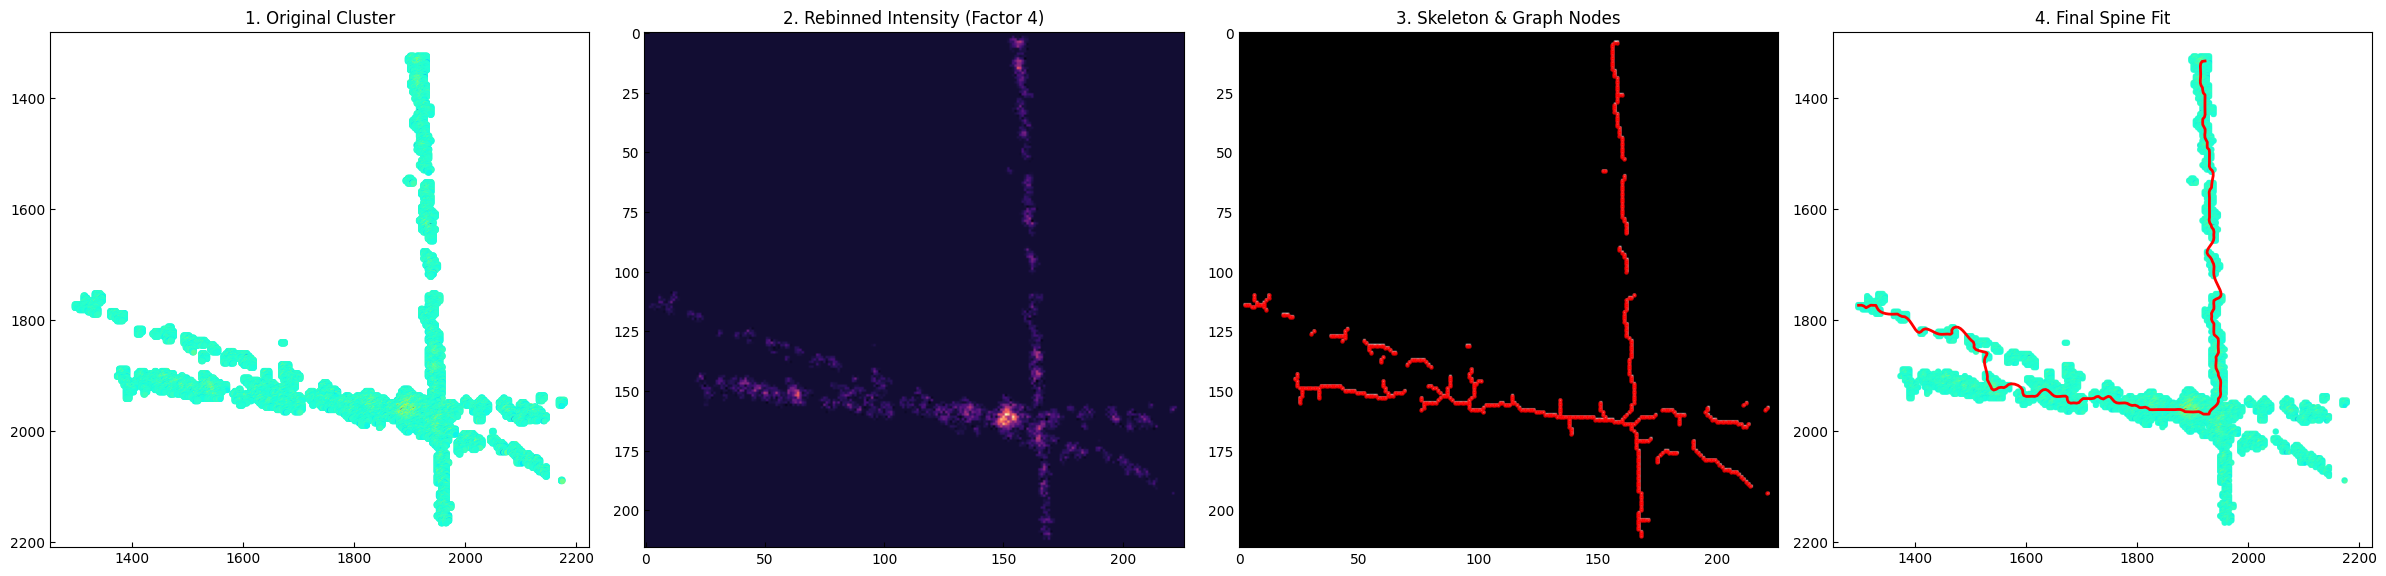

In [27]:
for i in range(10, 20):
    curved.plot_debug(i)